## Geometry

We want to model a quarter of a plate with an elliptical hole. The domain itself is represented by collocation points, the boundaries are represented by uniformly sampled points along the perimeter.

In [27]:
import torch
from torch.optim.lr_scheduler import StepLR
import numpy as np
from scipy.stats import qmc
from plotly.express.colors import sequential
import plotly.graph_objects as go
import plotly.figure_factory as ff
from tqdm import tqdm
#import wandb
import matplotlib.pyplot as plt

torch.set_default_dtype(torch.float64)
from global_constants import  B0, EPS0, MU, LBD, RATIO


L = 1
# Number of collocation points
N = 25
#compression and stretch of the square , between  >0 and <1/2, 1/4 -> square
alpha = 1/4 * np.pi
#rotation of the rhombus -> +-1/4 = sqaure 
beta = -1/4 * np.pi

# Epochs
epochs = 800
# Batch size
batch_size = 64
# Leanring rate
lr = 0.01 #normally 0.001
# Scheduler step width
scheduler_step = 150 #normally 2000
# Gamma factor of scheduler
scheduler_gamma = 0.7

# Number of hidden neurons
hn = 50

# Weight of PDE loss
W_PDE = 0.001
# Weight of Neumann loss
W_NEU = 0.05
# Weight of data losses
W_STRESS = 0.0
W_DISP = 0.0

#error in rotation function
# def rotation(angle, list):
#     t = list[:,1]/torch.absolute(list[:,1])*torch.arccos(((list[:,0]*1)+(list[:,1]*0))/(torch.sqrt((list[:,0]**2+list[:,1]**2)*(1+0))))
#     x_rot = torch.sqrt(list[:,0]**+2 + list[:,1]**2) * torch.cos(t+angle)
#     y_rot =torch.sqrt(list[:,0]**+2 + list[:,1]**2) * torch.sin(t+angle)
#     return torch.column_stack([x_rot,y_rot])


def point_rotation(theta, p):
    # Use the x and y rotation formulas to rotate around the origin    
    p_rot_x = (p[:,0]*np.cos(theta)-p[:,1]*np.sin(theta))
    p_rot_y = (p[:,0]*np.sin(theta)+ p[:,1]*np.cos(theta))
    return np.column_stack([p_rot_x, p_rot_y])

def torch_point_rotation(theta, p):
    # Use the x and y rotation formulas to rotate around the origin    
    p_rot_x = (p[:,0]*torch.cos(theta)-p[:,1]*torch.sin(theta))
    p_rot_y = (p[:,0]*torch.sin(theta)+ p[:,1]*torch.cos(theta))
    return torch.column_stack([p_rot_x, p_rot_y])



#rak = rotation(beta, ((5,5),(4,4)))


# Create collocation points
points = 2*L * qmc.LatinHypercube(d=2).random(4*N**2)
mask_right_top = np.tan(alpha)*(-points[:, 0]+(1/np.tan(alpha)*3*L*np.sin(alpha))) >= points[:,1]
mask_left_top = np.tan(alpha)*(points[mask_right_top][:, 0]+(1/np.tan(alpha)*L*np.sin(alpha))) >= points[mask_right_top][:, 1]
mask_right_bottom = np.tan(alpha)*(points[mask_right_top][mask_left_top][:, 0] - (1/np.tan(alpha)*L*np.sin(alpha))) <= points[mask_right_top][mask_left_top][:,1]
mask_left_bottom = np.tan(alpha)*(-points[mask_right_top][mask_left_top][mask_right_bottom][:, 0] + (1/np.tan(alpha)*L*np.sin(alpha))) <= points[mask_right_top][mask_left_top][mask_right_bottom][:,1]
collocation = torch.tensor(point_rotation(beta, points[mask_right_top][mask_left_top][mask_right_bottom][mask_left_bottom]), requires_grad=True).double()

# Boundary points
left_x_top = torch.linspace(0, L*np.cos(alpha), N, requires_grad=True).double()
left_y_top = torch.linspace(L*np.sin(alpha), 2*L*np.sin(alpha), N, requires_grad=True).double()
left_top = torch.column_stack([left_x_top, left_y_top]).double()
left_top = torch_point_rotation(torch.tensor(beta), left_top)


left_x_bottom = torch.linspace(0, L*np.cos(alpha), N).double()
left_y_bottom = torch.linspace(L*np.sin(alpha), 0, N, requires_grad=True).double()
left_bottom = torch.column_stack([left_x_bottom, left_y_bottom]).double()
left_bottom = torch_point_rotation(torch.tensor(beta), left_bottom)

right_x_top = torch.linspace(L*np.cos(alpha), 2*L*np.cos(alpha), N, requires_grad=True).double()
right_y_top = torch.linspace(2*L*np.sin(alpha), L*np.sin(alpha), N, requires_grad=True).double()
right_top = torch.column_stack([right_x_top, right_y_top]).double()
right_top = torch_point_rotation(torch.tensor(beta), right_top)

right_x_bottom = torch.linspace(L*np.cos(alpha), 2*L*np.cos(alpha), N, requires_grad=True).double()
right_y_bottom = torch.linspace(0, L*np.sin(alpha), N, requires_grad=True).double()
right_bottom = torch.column_stack([right_x_bottom, right_y_bottom]).double()
right_bottom = torch_point_rotation(torch.tensor(beta), right_bottom)


# Visualize geometry
with torch.no_grad():
    mode = "markers"
    gray = dict(color="#C9C5BC")
    green = dict(color="#006561")
    black = dict(color="black")
    orange = dict(color="#ff7f0e")
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=collocation[:, 0], y=collocation[:, 1], mode=mode, marker=gray))
    fig.add_trace(go.Scatter(x=right_top[:, 0], y=right_top[:, 1], mode=mode, marker=black))
    fig.add_trace(go.Scatter(x=right_bottom[:, 0], y=right_bottom[:, 1], mode=mode, marker=orange))
    fig.add_trace(go.Scatter(x=left_top[:, 0], y=left_top[:, 1], mode=mode, marker=green))
    fig.add_trace(go.Scatter(x=left_bottom[:, 0], y=left_bottom[:, 1], mode=mode, marker=orange))
    fig.layout.yaxis.scaleanchor = "x"
    fig.update_layout(
        template="none",
        width=400,
        height=400,
        margin=dict(l=0, r=0, b=0, t=0),
        showlegend=False,
    )
    fig.update_xaxes(visible=False)
    fig.update_yaxes(visible=False)
    fig.show()

## The ANN model that approximates the displacement field

An ANN might be considered as a generic function approximator. In this case, it should approximated the function $u: \mathcal{R}^2 \rightarrow \mathcal{R}^2$ with five hidden layers having 50 neurons each.

In [28]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.hidden_layer1 = torch.nn.Linear(2, hn)
        self.hidden_layer2 = torch.nn.Linear(hn, hn)
        self.hidden_layer3 = torch.nn.Linear(hn, hn)
        self.hidden_layer4 = torch.nn.Linear(hn, hn)
        self.hidden_layer5 = torch.nn.Linear(hn, hn)
        # self.hidden_layer6 = torch.nn.Linear(hn, hn)
        # self.hidden_layer7 = torch.nn.Linear(hn, hn)
        # self.hidden_layer8 = torch.nn.Linear(hn, hn)
        self.output_layer = torch.nn.Linear(hn, 2)

    def forward(self, inputs):
        layer1_out = torch.tanh(self.hidden_layer1(inputs))
        layer2_out = torch.tanh(self.hidden_layer2(layer1_out))
        layer3_out = torch.tanh(self.hidden_layer3(layer2_out))
        layer4_out = torch.tanh(self.hidden_layer4(layer3_out))
        layer5_out = torch.tanh(self.hidden_layer5(layer4_out))
        # layer6_out = torch.tanh(self.hidden_layer5(layer5_out))
        # layer7_out = torch.tanh(self.hidden_layer5(layer6_out))
        # layer8_out = torch.tanh(self.hidden_layer5(layer7_out))
        output = self.output_layer(layer5_out)
        return output


net = Net()

## The physics

We want to solve linear elasticity on the domain, which means ultimately that we want to minimize the residual of the following PDE 
$$\frac{\partial \sigma_{11}}{\partial x_1} + \frac{\partial \sigma_{12}}{\partial x_2} - b_1 = 0$$
$$\frac{\partial \sigma_{21}}{\partial x_1} + \frac{\partial \sigma_{22}}{\partial x_2} - b_2 = 0$$
with stress 
$$ \sigma_{ij} = 2\mu \varepsilon_{ij} + \lambda \varepsilon_{kk} \delta_{ij} $$
and strain 
$$ \varepsilon_{ij} = \frac{1}{2} \left( \frac{\partial u_i}{\partial x_j} +  \frac{\partial u_j}{\partial x_i}\right).$$

In [29]:
def epsilon(x):
    # Compute deformation gradient
    dudx = torch.func.jacrev(net)(x)
    return 0.5 * (dudx + dudx.T)

def sigma(x):
    # Compute (small deformation) strain
    eps = epsilon(x)
    # Compute linear elastic strain (assuming plane strain)
    return 2.0 * MU * eps + LBD * torch.trace(eps) * torch.eye(2)


def pde_residual(x):
    # Compute stress gradient
    dsdx = torch.func.jacrev(sigma)(x)
    # Momentum balance in x direction
    residual_x = dsdx[0, 0, 0] + dsdx[0, 1, 1] - B0
    # Momentum balance in y direction
    residual_y = dsdx[1, 0, 0] + dsdx[1, 1, 1]
    return residual_x, residual_y





In [30]:
mse = torch.nn.MSELoss()

def compute_physics_losses(collocation):
    # pde
    res_x, res_y = torch.vmap(pde_residual)(collocation)
    zeros = torch.zeros_like(res_x)
    pde_error = mse((res_x), zeros) + mse((res_y), zeros)

    #left_top boundary
    stress_l_top = torch.vmap(sigma)(left_top)
    s_xx = stress_l_top[:,0,0]
    s_xy = stress_l_top[:,0,1]
    s_yy = stress_l_top[:,1,1]
    zeros = torch.zeros_like(s_yy)
    left_top_error = mse((s_xx*-np.sin(beta+ 1/4*np.pi)+s_xy*np.cos(beta+ 1/4*np.pi)), zeros) + mse((s_xy*-np.sin(beta + 1/4*np.pi)+s_yy*np.cos(beta + 1/4*np.pi)), zeros) 


    # right_top boundary
    pred_r_top = net(right_top)
    rotated_pred_r_top = torch_point_rotation(torch.tensor(-beta - 1/4*np.pi), pred_r_top)
    bc_right = EPS0 * L * torch.ones_like(rotated_pred_r_top[:, 0])
    right_top_error = mse(pred_r_top[:, 0], bc_right)

    # left_bottom boundary
    pred_l_bottom = net(left_bottom)
    rotated_pred_l_bottom = torch_point_rotation(torch.tensor(-beta - 1/4*np.pi), pred_l_bottom)
    bc_left = torch.zeros_like(rotated_pred_l_bottom[:, 0])
    left_bottom_error =mse(rotated_pred_l_bottom[:, 0], bc_left)
                                    
   
    # right_bottom boundary
    pred_r_bottom = net(right_bottom)
    rotated_pred_r_bottom = torch_point_rotation(torch.tensor(-beta - 1/4*np.pi), pred_r_bottom)
    bc_bottom = torch.zeros_like(rotated_pred_r_bottom[:, 1]) 
    right_bottom_error = mse(rotated_pred_r_bottom[:, 1], bc_bottom)


    return (left_top_error, right_top_error, left_bottom_error, right_bottom_error, pde_error)

## Training 

Starting with Adam optimizer...


100%|██████████| 500/500 [02:11<00:00,  3.80it/s]


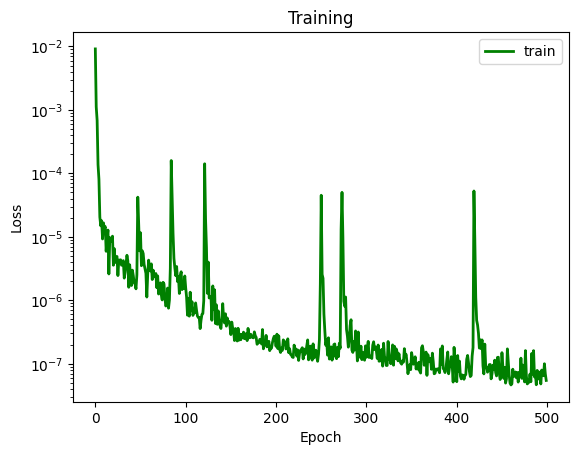

In [31]:
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=scheduler_step, gamma=scheduler_gamma)
history = []

print("Starting with Adam optimizer...")
for epoch in tqdm(range(epochs)):
    # Permutation to shuffle collocation points randomly in each epoch
    permutation = torch.randperm(collocation.size()[0])

    for i in range(0, collocation.size()[0], batch_size):
        indices = permutation[i : i + batch_size]
        collo = collocation[indices]
        optimizer.zero_grad()

        # Compute physics losses
        left_top_l, right_top_l, left_bottom_l, right_bottom_l, pde_l = compute_physics_losses(collo)
        # # Get samples from reference solution
        # samples = torch.randperm(data_output.size()[0])[::100]
        # # Reference solutions
        # s_data = data_output[samples, 0:3]
        # e_data = data_output[samples, 4:7]
        # u_data = data_output[samples, 7:10]
        # # Predictions
        # s_pred = torch.vmap(sigma)(data_input[samples, 0:2])
        # e_pred = torch.vmap(epsilon)(data_input[samples, 0:2])
        # u_pred = net(data_input[samples, 0:2])
        # # Compute data losses
        # ds_xx = mse(s_data[:, 0], s_pred[:, 0, 0])
        # ds_yy = mse(s_data[:, 1], s_pred[:, 1, 1])
        # ds_xy = mse(s_data[:, 2], s_pred[:, 0, 1])
        # stress_l = ds_xx + ds_yy + ds_xy
        # de_xx = mse(e_data[:, 0], e_pred[:, 0, 0])
        # de_yy = mse(e_data[:, 1], e_pred[:, 1, 1])
        # de_xy = mse(e_data[:, 2], e_pred[:, 0, 1])
        # strain_l = de_xx + de_yy + de_xy
        # du_x = mse(u_data[:, 0], u_pred[:, 0])
        # du_y = mse(u_data[:, 1], u_pred[:, 1])
        # disp_l = du_x + du_y

        # Aggregate losses
        dirichlet_losses = right_top_l + left_bottom_l + right_bottom_l
        neumann_loss = left_top_l
        loss = (
            dirichlet_losses
            + W_PDE * pde_l
            + W_NEU * neumann_loss
            #+ W_STRESS * stress_l
            #+ W_DISP * disp_l
        )


        # Make optimization step after batch
        loss.backward(retain_graph=True)
        optimizer.step()

    # Make scheduler step after full epoch
    scheduler.step()
    
    # append loss to history (=for plotting)
    with torch.autograd.no_grad():
        history.append(float(loss.data))



plt.plot(history, c='g', label='train', linewidth=2.0)
plt.yscale("log")
plt.title("Training")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()



## Visualization of results

In [32]:
# Create a validation domain different from the training domain
val_x, val_y = np.meshgrid(np.linspace(0, 2*L, 100), np.linspace(0, 2*L, 100))
val_domain = np.vstack([val_x.ravel(), val_y.ravel()]).T

mask_right_top = np.tan(alpha)*(-val_domain[:, 0]+(1/np.tan(alpha)*3*L*np.sin(alpha))) >= val_domain[:,1]
mask_left_top = np.tan(alpha)*(val_domain[mask_right_top][:, 0]+(1/np.tan(alpha)*L*np.sin(alpha))) >= val_domain[mask_right_top][:, 1]
mask_right_bottom = np.tan(alpha)*(val_domain[mask_right_top][mask_left_top][:, 0] - (1/np.tan(alpha)*L*np.sin(alpha))) <= val_domain[mask_right_top][mask_left_top][:,1]
mask_left_bottom = np.tan(alpha)*(-val_domain[mask_right_top][mask_left_top][mask_right_bottom][:, 0] + (1/np.tan(alpha)*L*np.sin(alpha))) <= val_domain[mask_right_top][mask_left_top][mask_right_bottom][:,1]
val = torch.tensor(point_rotation(-1/4*np.pi , val_domain[mask_right_top][mask_left_top][mask_right_bottom][mask_left_bottom]), requires_grad=True).double()


# Compute model predictions on the validation domain
disp = net(val)
def_val = val + disp
#def_val = torch_point_rotation(torch.tensor(-beta - 1/4*np.pi), def_val)
stress = torch.vmap(sigma)(val)
print("hallo",np.shape(stress))
#rotated_stress = torch_point_rotation(torch.tensor(beta - 1/4*np.pi), torch_point_rotation(torch.tensor(-beta + 1/4*np.pi), stress))
mises = torch.sqrt(
    stress[:, 0, 0] ** 2
    + stress[:, 1, 1] ** 2
    - stress[:, 0, 0] * stress[:, 1, 1]
    + 3 * stress[:, 0, 1] ** 2
)
# print([loss.item() for loss in compute_les(val)])

@torch.no_grad()
def make_plot(x, y, variable, title, cmap=sequential.Viridis, size=8.0):
    fig = go.Figure()

    rotated_left_top = torch_point_rotation(torch.tensor(-beta - 1/4*np.pi), left_top)
    rotated_left_bottom = torch_point_rotation(torch.tensor(-beta - 1/4*np.pi), left_bottom)
    rotated_right_top = torch_point_rotation(torch.tensor(-beta - 1/4*np.pi), right_top)
    rotated_right_bottom = torch_point_rotation(torch.tensor(-beta - 1/4*np.pi), right_bottom)


    # Plot boundaries
    m = dict(color="black")
    fig.add_trace(go.Scatter(x=rotated_left_top[:, 0], y=rotated_left_top[:, 1], mode="lines", marker=m))
    fig.add_trace(go.Scatter(x=rotated_left_bottom[:, 0], y=rotated_left_bottom[:, 1], mode="lines", marker=m))
    fig.add_trace(go.Scatter(x=rotated_right_top[:, 0], y=rotated_right_top[:, 1], mode="lines", marker=m))
    fig.add_trace(go.Scatter(x=rotated_right_bottom[:, 0], y=rotated_right_bottom[:, 1], mode="lines", marker=m))

    # Plot variable values
    m = dict(color=variable, colorscale=cmap, size=size, colorbar=dict(thickness=10))
    fig.add_trace(go.Scatter(x=x, y=y, marker=m, mode="markers"))

    # plot settings
    fig.layout.yaxis.scaleanchor = "x"
    fig.update_layout(
        template="none", width=400, height=400, title=title, showlegend=False
    )
    fig.update_xaxes(visible=False)
    fig.update_yaxes(visible=False)
    fig.show()


# Compute data error
s_pred = torch.vmap(sigma)(val)
ds_xx = 3 * EPS0 - s_pred[:,0, 0]
print("Young's modulus is ",(MU*(3*LBD+2*MU))/(LBD*MU)) #Young's modulus 
ds_yy = s_pred[:, 1, 1]
ds_xy = s_pred[:, 0, 1]
ds_xx_pct = (3 * EPS0 - s_pred[:,0, 0]) / (3 * EPS0) *100


# Plot stresses
make_plot(*def_val.T, stress[:, 0, 0], "Stress xx")
make_plot(*def_val.T, stress[:, 0, 1], "Stress xy")
make_plot(*def_val.T, stress[:, 1, 1], "Stress yy")
make_plot(*def_val.T, mises, "Mises stress")

# Plot displacements
make_plot(*def_val.T, disp[:, 0], "Displacement in x", cmap=sequential.Inferno)
make_plot(*def_val.T, disp[:, 1], "Displacement in y", cmap=sequential.Inferno)

# Plot stress errors
cmap = sequential.RdBu_r
make_plot(*val[:, 0:2].T, ds_xx, "Stress error xx", size=2.0, cmap=cmap)
make_plot(*val[:, 0:2].T, ds_yy, "Stress error yy", size=2.0, cmap=cmap)
make_plot(*val[:, 0:2].T, ds_xy, "Stress error xy", size=2.0, cmap=cmap)
make_plot(*val[:, 0:2].T, ds_xx_pct, "Stress error xx in %", size=2.0, cmap=cmap)


hallo torch.Size([2485, 2, 2])
Young's modulus is  4.0
